In [ ]:
import re
import zlib
import base64
import datetime
import numpy as np
import pandas as pd
import json
import configparser
from utils import *
from sys import platform
from elasticsearch import Elasticsearch

# import torch
# from tslearn.metrics import dtw, dtw_path
# from tslearn.metrics import lcss, lcss_path
# from transformers import BertTokenizer, BertModel
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
# model = BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
# model = model.to(device)
# device

In [ ]:
cf = configparser.ConfigParser()
cf.read('config/config.cfg')

env = 'DEVELOP'
if 'win' in platform:
    env = 'DEVELOP'
elif 'linux' in platform:
    env = 'PRODUCT'
    
class EsCtrl(object):
    def __init__(self):
        self.es_ctrl = Elasticsearch(cf['ENV_'+env]['ADDR'], ca_certs=cf['ELASTICSEARCH']['CA_CERTS'])

    def query_index_logs(self, index):
        # query = {
        #     "match": {
        #         "trace": "com_ericsson_trithread:INFO"
        #     }
        # }
        #data = self.es_ctrl.search(index=index, query=query, scroll='1s', size=10000)
        data = self.es_ctrl.search(index=index, scroll='1s', size=10000)
        sid = data['_scroll_id']
        scroll_size = len(data['hits']['hits'])
        res = []
        while scroll_size > 0:
            # Before scroll, process current batch of hits
            res.extend(data['hits']['hits'])
            data = self.es_ctrl.scroll(scroll_id=sid, scroll='1s')
            # Update the scroll ID
            sid = data['_scroll_id']
            # Get the number of results that returned in the last scroll
            scroll_size = len(data['hits']['hits'])
        return res

    def query_indices(self):
        res = []
        for key in self.es_ctrl.indices.get_alias().keys():
            if len(key) > 0:
                if '.analyzed_' in key:
                    res.append(key.replace('.analyzed_', ''))
        return res

    def is_exists(self, index):
        return self.es_ctrl.indices.exists(index=index)

    def count_index(self, index):
        return self.es_ctrl.count(index=index)['count']

    def store_index(self, index, data):
        data = deflate_and_base64_encode(json.dumps(data).encode('utf-8'))
        return self.es_ctrl.index(index=index, body={'content': data})

    def query_index(self, index):
        data = self.es_ctrl.search(index=index)
        data = json.loads(decode_base64_and_inflate(data['hits']['hits'][0]['_source']['content']))
        return data

In [ ]:
############################################ Data Clean ################################################
def package_kv(df):
    res = {}
    k_type = {}
    for i, (kv,index,timestamp) in enumerate(zip(df.kv.values, df['index'].values, df.timestamp.values)):
        for item in kv:
            if len(item[1]) > 0:
                if item[0] in res:
                    res[item[0]].append(item[1]  + [timestamp] + [str(i)] + [index]) # [value1,value2,value3,timestamp,process_index,global_index]
                else:
                    res[item[0]] = [item[1]  + [timestamp] + [str(i)] + [index]]
    for key in res.keys():
        width = max(map(len, res[key])) # get max width
        type_list = []
        for i, item in enumerate(res[key]):
            if '0x' in item[0]:
                type_list.append('register')
            elif item[0].isupper():
                type_list.append('discrete')
            else:
                type_list.append('continuous')
                
            if len(item) != width:
                tmp = [0 for _ in range(0, width)]
                tmp[-3] = item[-3]
                tmp[-2] = item[-2]
                tmp[-1] = item[-1]
                res[key][i] = tmp
        res[key] = np.array(res[key]).transpose().tolist() # matrix transposition
        k_type[key] = 'discrete' if len(set(type_list)) > 1 else list(set(type_list))[0]
    return res,k_type


def package_inverted_index_table(table, key, data):
    def clean_special_symbols(text):
        for ch in ['/','*','{','}','[',']','(',')','#','+','-','!','=',':',',','"']:
            if ch in text:
                text = text.replace(ch," ")
        return re.sub(" +", " ", text)
    for index, msg in data:
        for word in set(clean_special_symbols(msg).split(' ')):
            w = word.lower()
            if w not in table:
                table[w] = {'x': [index], 'y': [key]} # x:global index, y: yaxis num 
            else:
                table[w]['x'].append(index)
                table[w]['y'].append(key)


def clean_data(esdata):
    def clean_msg_special_symbols(text):
        for ch in ['{', '}', '[', ']', '(', ')', '"', '::']:
            if ch in text:
                text = text.replace(ch, " ")
        return re.sub(" +", " ", text)

    story = []
    for item in esdata:
        if 'msg' in item['_source']:
            tmp = clean_msg_special_symbols(item['_source']['msg'])
            if len(re.findall('process \= (.*?)$', tmp)) > 0:
                process = re.findall('process \= (.*?),', tmp)[0]
                msg = re.findall('msg \= (.*?)$', tmp)[0]
            #                 fileAndLine = re.findall('fileAndLine \= \"(.*?)\"',item['_source']['msg'])[0].split(':')[0]
            # elif len(re.findall('procname \= (.*?)$', tmp)) > 0:
            #     process = re.findall('procname \= (.*?),', tmp)[0]
            #     #                 msg = tmp.split(',')[2].replace('"','').replace('}','').replace('{','')
            #     msg = tmp
            else:
                process = 'main'
                msg = tmp
                
            msg = msg.replace('= ',':').replace(' = ',':').replace(': ',':').replace(' : ',':').replace('=',':')

            for elm in re.split('[: ]',msg):
                if elm.isupper():
                    msg = re.sub('[: ]'+elm, ':'+elm, msg)

            msg = re.sub('(:(?!-).*?[ $])', r'\1,', (msg + ' $'))
            # msg
            kv = []
            for k, v in re.findall('([A-Za-z0-9_.]+?)[ ]?[:=][ ]?(.*?)[,$]', msg):
                if len(v.strip()) > 0:
                    if (v.strip()+'xx').lower()[0:2] == '0x':
                        kv.append((k.strip()+'(r)',  [v.strip()]))
                    elif v.strip()[0].isalpha():
                        kv.append((k.strip()+'(d)', [v.strip()]))
                    else:
                        kv.append((k.strip()+'(c)', re.findall('[0-9.]+', v)))
                        
            millisecond = str(item['_source']['millisecond'])
            supply_zero = ''
            for _ in range(0, 9-len(millisecond)):
                supply_zero = supply_zero + '0'
            millisecond = supply_zero + millisecond
            story.append([item['_source']['device'], item['_source']['trace'], process,  item['_source']['logtime'][:-1] + '.' + millisecond, item['_source']['msg'], kv])
            
    story = pd.DataFrame(story, columns=['device', 'trace', 'process', 'timestamp', 'msg', 'kv']).sort_values('timestamp',ascending=True).reset_index(drop=True)

    story_line = {}
    inverted_index_table = {}
    for dev in set(story.device.values):
        data = story.loc[(story['device'] == dev), :].reset_index(drop=True)
        sub_inverted_index_table = {}
        for i, process_name in enumerate(sorted(set(data.process.values), key=list(data.process.values).index)):
            process = data.loc[(data['process'] == process_name), :].reset_index()
            process['index'] = process['index'].astype(str)
            process_start_time = process['timestamp'][0]
            process_start_count = process['index'][0]
            process_end_time = process['timestamp'][process.shape[0] - 1]
            process_end_count = process['index'][process.shape[0] - 1]
            package_inverted_index_table(sub_inverted_index_table, i, zip(process['index'].values, process.msg.values))
            msg = dict(zip(process['index'].values, [str(a) + '||' + b + '||' + c for a, b, c in
                                                     zip(process.index.values, process.timestamp.values,
                                                         process.msg.values)]))

            kv,k_type = package_kv(process)
            if dev not in story_line:
                story_line[dev] = [{'process': process_name, 'start_time': process_start_time, 'start_count': process_start_count, 'end_time': process_end_time, 'end_count': process_end_count, 'msg': msg, 'kv': kv}]
            else:
                story_line[dev].append({'process': process_name, 'start_time': process_start_time, 'start_count': process_start_count, 'end_time': process_end_time, 'end_count': process_end_count, 'msg': msg, 'kv': kv})
        inverted_index_table[dev] = sub_inverted_index_table
    return {'story_line': story_line, 'inverted_index_table': inverted_index_table}


def apply_filter_by_keywords(df):
    if (len(set(df['msg']) & set([':', '='])) > 0):
        return False
    return True


def apply_filter_digit(df):
    return re.sub('\d+', '', df['msg'])


def apply_keyword_highlight(df, keywords, color_highlight):
    tmp = [item.lower() for item in keywords]
    for item in tmp:
        if (item == 'abn:') & (item in df['msg'].lower()):
            return color_highlight
        elif len(set(df['msg'].lower().split(' ')).intersection(set(tmp))) > 0:
            return color_highlight
    return df['status']


def cal_time_difference(start, end):
    return datetime.datetime.strptime(end, "%H:%M:%S") - datetime.datetime.strptime(start, "%H:%M:%S")


############################################ XML Compression and Decompression ################################################
def decode_base64_and_inflate(b64string):
    decoded_data = base64.b64decode(b64string)
    return zlib.decompress(decoded_data , -15)


def deflate_and_base64_encode(string_val):
    zlibbed_str = zlib.compress(string_val)
    compressed_string = zlibbed_str[2:-4]
    return base64.b64encode(compressed_string).decode("utf-8")

############################################ Text ecoder ################################################
def pretrained_model_encode_msg(object1, object2):
    with torch.no_grad():
        object1_inputs = tokenizer(list(object1.msg.values), padding=True, truncation=True, return_tensors="pt").to(device)
        object1_outputs = model(**object1_inputs)

        object2_inputs = tokenizer(list(object2.msg.values), padding=True, truncation=True, return_tensors="pt").to(device)
        object2_outputs = model(**object2_inputs)
    return object1_outputs, object2_outputs

def onehot_encode_string(str1,str2):
    data = []
    data.extend(str1)
    data.extend(str2)
    values = np.array(data)

    # integer encode
    label_encoder = LabelEncoder().fit(values)
    integer_encoded = label_encoder.transform(values)

    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoder = OneHotEncoder(sparse=False).fit(integer_encoded)

    encoder1 = onehot_encoder.transform(label_encoder.transform(str1).reshape(len(str1), 1))
    encoder2 = onehot_encoder.transform(label_encoder.transform(str2).reshape(len(str2), 1))
    # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
    # print(inverted)
    return encoder1,encoder2

############################################ Space Vectors Algorithm ################################################
def cal_lcss_path_and_score(s_y1, s_y2):
    path, score = lcss_path(s_y1, s_y2)
    return path, score

def cal_dtw_path_and_score(s_y1, s_y2):
    path, score = dtw_path(s_y1, s_y2)
    return path, score

In [ ]:
from extract import *

with open(cf['ENV_'+env]['LOG_STORE_PATH'] + 'ru_lock_unlock_dpd_hw_fault_air6419_mongoose_2022_10_10', "rb") as myfile:
    S = myfile.read()
res = json.loads(gzip.decompress(S))

In [ ]:
dataset[0]

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics


numpy.random.seed(0)
n_ts, sz, d = 2, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d, random_state=5)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_scaled = scaler.fit_transform(dataset)

lcss_path, sim_lcss = metrics.lcss_path(dataset_scaled[0, :, 0], dataset_scaled[1, :40, 0], eps=1.5)
dtw_path, sim_dtw = metrics.dtw_path(dataset_scaled[0, :, 0], dataset_scaled[1, :40, 0])

plt.figure(1, figsize=(8, 8))

plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :40, 0], "g-", label='Second time series')

for positions in lcss_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')
plt.legend()
plt.title("Time series matching with LCSS")

plt.figure(2, figsize=(8, 8))
plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :40, 0], "g-", label='Second time series')

for positions in dtw_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')

plt.legend()
plt.title("Time series matching with DTW")

plt.tight_layout()
plt.show()

In [ ]:
kv_a = [[int(item)] for item in story_a['kv']['txlProcBranchH']['txAtt(c)'][0]]
kv_b = [[int(item)] for item in story_b['kv']['txlProcBranchH']['txAtt(c)'][0]]
dataset = [kv_a, kv_b]
dataset

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics


# numpy.random.seed(0)
# n_ts, sz, d = 2, 100, 1
# dataset = random_walks(n_ts=n_ts, sz=sz, d=d, random_state=5)

kv_a = [int(item) for item in story_a['kv']['txlProcBranchH']['txAtt(c)'][0]]
kv_b = [int(item) for item in story_b['kv']['txlProcBranchH']['txAtt(c)'][0]]
[kv_b.insert(0,0) for _ in range(0, len(kv_a) - len(kv_b))]

dataset = [kv_a, kv_b]
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_scaled = scaler.fit_transform(dataset)

lcss_path, sim_lcss = metrics.lcss_path(dataset_scaled[0, :, 0], dataset_scaled[1, :, 0], eps=1.5)
dtw_path, sim_dtw = metrics.dtw_path(dataset_scaled[0, :, 0], dataset_scaled[1, :, 0])

plt.figure(1, figsize=(8, 8))

plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :, 0], "g-", label='Second time series')

for positions in lcss_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')
plt.legend()
plt.title("Time series matching with LCSS")

plt.figure(2, figsize=(8, 8))
plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :, 0], "g-", label='Second time series')

for positions in dtw_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')

plt.legend()
plt.title("Time series matching with DTW")

plt.tight_layout()
plt.show()

In [ ]:
from extract import *

path = 'exiosuu_LTE_TALAGAKOCAK_GH_2052.log'
fe = FileExtract(path,'exiosuu_LTE_TALAGAKOCAK_GH_2052.log')

In [ ]:
if fe.is_extractable:
    res = fe.extract()

In [1]:
from tslearn.metrics import dtw, dtw_path
from tslearn.metrics import lcss, lcss_path
import numpy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from extract import *

def cal_lcss_path_and_score(s_y1, s_y2):
    path, score = lcss_path(s_y1, s_y2)
    return path, score

def cal_dtw_path_and_score(s_y1, s_y2):
    path, score = dtw_path(s_y1, s_y2)
    return path, score

with open(cf['ENV_'+env]['LOG_STORE_PATH'] + 'GLT_SUKAMULYA_CBN_CM_BXP_2051_telog.log_BXP_2051_radio6626_2022_10_10', "rb") as myfile:
    S = myfile.read()
story_a = json.loads(gzip.decompress(S))

with open(cf['ENV_'+env]['LOG_STORE_PATH'] + 'exiosuu_LTE_TALAGAKOCAK_GH_2052.log_BXP_2052_radio6626_2022_10_10', "rb") as myfile:
    S = myfile.read()
story_b = json.loads(gzip.decompress(S))

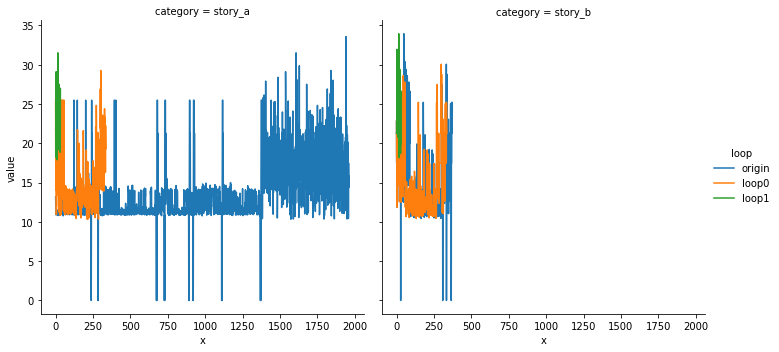

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from bisect import bisect

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def del_list_inplace(l, id_to_del):
    for i in sorted(id_to_del, reverse=True):
        del(l[i])

keyword = 'Pma(c)'
final = pd.DataFrame()
kv_a_global_indices = [int(item) for item in story_a['kv']['txlProcBranchH'][keyword][-1]]
kv_b_global_indices = [int(item) for item in story_b['kv']['txlProcBranchH'][keyword][-1]]

kv_a = [[i, kv_a_global_indices[i], float(item)] for i, item in enumerate(story_a['kv']['txlProcBranchH'][keyword][0])]
kv_b = [[i, kv_b_global_indices[i], float(item)] for i, item in enumerate(story_b['kv']['txlProcBranchH'][keyword][0])]

kv_a = pd.DataFrame(kv_a, columns=['x', 'global_index','value'])
kv_a['category'] = 'story_a'
kv_a['loop'] = 'origin'

kv_b = pd.DataFrame(kv_b, columns=['x', 'global_index','value'])
kv_b['category'] = 'story_b'
kv_b['loop'] = 'origin'

final = final.append(kv_a).reset_index(drop=True)
final = final.append(kv_b).reset_index(drop=True)

for loop,_ in enumerate(range(0, 2)):
    path, score = lcss_path(NormalizeData(list(kv_a.value.values)), NormalizeData(list(kv_b.value.values)), eps=0.1)
    o_a = [[i, kv_a['global_index'][item[0]], kv_a['value'][item[0]]] for i, item in enumerate(path)]
    o_b = [[i, kv_b['global_index'][item[1]], kv_b['value'][item[1]]] for i, item in enumerate(path)]
    tmp_a = pd.DataFrame(o_a, columns=['x', 'global_index','value'])
    tmp_a['category'] = 'story_a'
    tmp_a['loop'] = 'loop'+str(loop)
    tmp_b = pd.DataFrame(o_b, columns=['x', 'global_index','value'])
    tmp_b['category'] = 'story_b'
    tmp_b['loop'] = 'loop'+str(loop)
    final = final.append(tmp_a).reset_index(drop=True)
    final = final.append(tmp_b).reset_index(drop=True)

    kv_a = kv_a.drop(kv_a.index[ [item[0] for item in path] ]).reset_index(drop=True)
    kv_b = kv_b.drop(kv_b.index[ [item[1] for item in path] ]).reset_index(drop=True)
    
sns.relplot(
    data=final, kind="line",
    x="x", y="value", col="category", hue="loop")

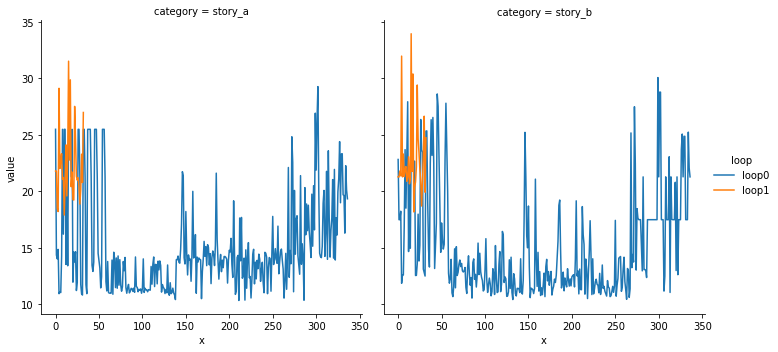

In [19]:
tmp = final.loc[(final['loop'] != 'origin'), :].reset_index(drop=True)
sns.relplot(
    data=tmp, kind="line",
    x="x", y="value", col="category", hue="loop")

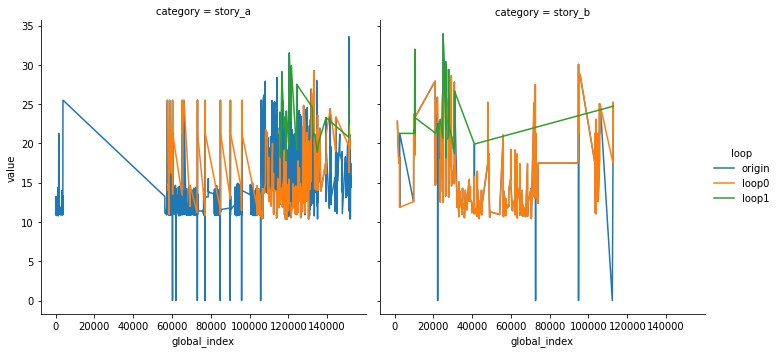

In [20]:
sns.relplot(
    data=final, kind="line",
    x="global_index", y="value", col="category", hue="loop")

In [21]:
process = 'txlProcBranchH'

highlight_story = {}
story_a_error_global_indices = []
for i, p in enumerate(story_a['inverted_index_table']['error']['process']):
    if p == process:
        story_a_error_global_indices.append(int(story_a['inverted_index_table']['error']['x'][i]))
        
story_b_error_global_indices = []
for i, p in enumerate(story_b['inverted_index_table']['error']['process']):
    if p == process:
        story_b_error_global_indices.append(int(story_b['inverted_index_table']['error']['x'][i]))

highlight_story = {'story_a':story_a_error_global_indices, 'story_b':story_b_error_global_indices}

In [22]:
res = []
for loop in set(final.loop.values):
    for story in set(final.category.values):
        gi = final.loc[(final['loop'] == loop)&(final['category'] == story), :].global_index.values
        print(loop, story, len(gi))
        tmp = []
        for index in highlight_story[story]:
            tmp.append(bisect(gi, index))
        res.append({'loop':loop, 'category':story, 'position': sorted(set(tmp), key=tmp.index)})
res

loop0 story_b 337
loop0 story_a 337
loop1 story_b 33
loop1 story_a 33
origin story_b 374
origin story_a 1962


[{'loop': 'loop0', 'category': 'story_b', 'position': [276, 285]},
 {'loop': 'loop0',
  'category': 'story_a',
  'position': [10, 14, 19, 26, 30, 36, 45, 53, 136]},
 {'loop': 'loop1', 'category': 'story_b', 'position': [32]},
 {'loop': 'loop1', 'category': 'story_a', 'position': [0]},
 {'loop': 'origin', 'category': 'story_b', 'position': [309, 319]},
 {'loop': 'origin',
  'category': 'story_a',
  'position': [237, 283, 401, 674, 727, 890, 918, 1110, 1369]}]

In [23]:
np.std(final.loc[(final['loop'] == 'loop1')&(final['category'] == 'story_a'), :].value.values)

3.3108448842503293

In [24]:
np.std(final.loc[(final['loop'] == 'loop0')&(final['category'] == 'story_a'), :].value.values)

4.269166425093889

In [ ]:
a = 132
b = [0, 10, 30, 60, 100, 150, 210, 280, 340, 480, 530]
print(bisect(b, a))

In [ ]:
# 1.值范围 2.相似线段形态 3.highlight落在区间内 4.方差大

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def del_list_inplace(l, id_to_del):
    for i in sorted(id_to_del, reverse=True):
        del(l[i])

kv_a = [int(item) for item in story_a['kv']['txlProcBranchH']['txAtt(c)'][0]]
kv_b = [int(item) for item in story_b['kv']['txlProcBranchH']['txAtt(c)'][0]]
# [kv_b.insert(0,0) for _ in range(0, len(kv_a) - len(kv_b))]
final = pd.DataFrame()

path, score = cal_dtw_path_and_score(kv_a, kv_b)

# path, score = metrics.lcss_path(kv_a, kv_b, eps=1.5)
# o_a = [[i, kv_a[item[0]]] for i, item in enumerate(path)]
# o_b = [[i, kv_b[item[1]]] for i, item in enumerate(path)]
# tmp_a = pd.DataFrame(o_a, columns=['x','value'])
# tmp_a['category'] = 'story1'
# tmp_a['loop'] = 'loop'+str(loop)
# tmp_b = pd.DataFrame(o_b, columns=['x','value'])
# tmp_b['category'] = 'story2'
# tmp_b['loop'] = 'loop'+str(loop)
# final = final.append(tmp_a).reset_index(drop=True)
# final = final.append(tmp_b).reset_index(drop=True)

# del_a = [item[0] for item in path]
# del_list_inplace(kv_a, del_a)
# del_b = [item[1] for item in path]
# del_list_inplace(kv_b, del_b)

# sns.relplot(
#     data=final, kind="line",
#     x="x", y="value", col="category", hue="loop")

In [ ]:
path

In [ ]:
kv_a = [int(item) for item in story_a['kv']['txlProcBranchH']['txAtt(c)'][0]]
kv_b = [int(item) for item in story_b['kv']['txlProcBranchH']['txAtt(c)'][0]]

o_a = [[i, item] for i, item in enumerate(kv_a)]
o_b = [[i, item] for i, item in enumerate(kv_b)]

kv_a = pd.DataFrame(o_a, columns=['x','value'])
kv_a['category'] = 'story1'
kv_b = pd.DataFrame(o_b, columns=['x','value'])
kv_b['category'] = 'story2'
final = kv_a.append(kv_b).reset_index(drop=True)

sns.relplot(data=final, kind="line", x="x", y="value", col="category")

In [ ]:
kv_b

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 200)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

In [ ]:
kv_a = [int(item) for item in story_a['kv']['txlProcBranchH']['txAtt(c)'][0]]
kv_b = [int(item) for item in story_b['kv']['txlProcBranchH']['txAtt(c)'][0]]

[kv_b.insert(0,0) for _ in range(0, len(kv_a) - len(kv_b))]

s_y1 = numpy.concatenate((kv_a, kv_a)).reshape((-1, 1))
s_y2 = numpy.concatenate((kv_b, kv_b)).reshape((-1, 1))
sz = s_y1.shape[0]

path, sim = cal_dtw_path_and_score(s_y1, s_y2)

In [ ]:
plt.figure(1, figsize=(16, 16))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(s_y1, s_y2)

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), s_y2, "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- s_y1, numpy.arange(sz), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [ ]:
len(kv_b)

In [ ]:
kv_b

In [ ]:
def clean_msg_special_symbols(text):
    for ch in ['{', '}', '[', ']', '(', ')', '"', '::']:
        if ch in text:
            text = text.replace(ch, " ")
    return re.sub(" +", " ", text)
    
# msg = 'GaN Boost mode, set to boost mode Pma:-15.88[-41.54 -9.50] dB, DpdPma:-20.09[-20.58 -19.18] dB, Pmb:-15.88, TorPmb:-15.92[-50.88 -9.50] dB, avgTxPma:-18.14 dB, pmDpdIrqStat:0x00000000, pmScaleFactor: 65K'
# msg = 'txAtt:145, txAttPeak:0, dpGainLoopEnable:true, dpGainCtrlType:VVA_QPB93, torTemperature:820 (0.1C), torGainBackoff:0 (0.01dB), torGainLin:3.82825(0.01dB), torStepBit:9, cc1Ctrl1=0x00000100 , avgIMpa0:690 [mAmp]'
# msg = '[TXL_GAIN] Pma:-inf[-41.54 -9.50] dB, DpdPma:-inf[-inf -inf] dB, Pmb:-inf, TorPmb:-inf[-inf -9.50] dB, avgTxPma:-inf dB, pmDpdIrqStat:0x00000000, pmScaleFactor: 65K'
# msg = 'New event= EVENT_DEACTIVATE carrierId= 196908 fbsId= 1 fbsState= DISABLED cycleRequired= YES 110'
# msg = 'Event CARRIER_DEACTIVATE for carrierId:778'
# msg = 'Set event RX_SETUP_EVENT to time: 250[ms], from 0x13000e3'
# msg = 'New event= EVENT_SETUP carrierId= 771 fbsId= 1 fbsState= SETUP cycleRequired= NO 0'
# msg = '0-insertion for fbsId=2 event=EVENT_RELEASE '
# msg = 'DP trace: 339: 4909172 dllb_radon.c(4780) INFO:7: Status: stat{dpd=0x00808c10 pd{0=0x00808c10, 1=0x00808410} ec=0x000002ff}'
msg = 'txAtt:2500, txAttPeak:0, dpGainLoopEnable:true, dpGainCtrlType:DSA_AD_TXFE, torTemperature:670 (0.1C), torGainBackoff:0 (0.01dB), torGainLin:3.61826(0.01dB), torStepBit:10, cc0Ctrl1=0x00000100 , avgIMpa0:2090 [mAmp]'
msg = clean_msg_special_symbols(msg)
msg = msg.replace('= ',':').replace(' = ',':').replace(': ',':').replace(' : ',':').replace('=',':')

for elm in re.split('[: ]',msg):
    if elm.isupper():
        msg = re.sub('[: ]'+elm, ':'+elm, msg)

msg = re.sub('(:(?!-).*?[ $])', r'\1,', (msg + ' $'))
# msg
kv = []
for k, v in re.findall('([A-Za-z0-9_.]+?)[ ]?[:=][ ]?(.*?)[,$]', msg):
    if (v.strip()+'xx').lower()[0:2] == '0x':
        kv.append((k.strip()+'(r)',  [v.strip()]))
    elif v.strip()[0].isalpha():
        kv.append((k.strip()+'(d)', [v.strip()]))
    else:
        kv.append((k.strip()+'(c)', re.findall('[0-9.]+', v)))
kv

In [ ]:
import re

def clean_msg_special_symbols(text):
    for ch in ['{', '}', '[', ']', '(', ')', '"', '::', '\'']:
        if ch in text:
            text = text.replace(ch, " ")
    return re.sub(" +", " ", text)
# msg = 'BXP_2051: [Trace log from 2 restarts before]'
# msg = 'BXP_2050: [2022-07-14 21:47:47.132] txlProcBranchA dpdController.cc:3069 INFO:txAtt:1812, txAttPeak:0, dpGainLoopEnable:false, dpGainCtrlType:IDLE, torGainLin:2.61517, torStepBit:7, ccCtrl:0x00000100, avgIMpa0:470 [mAmp]'
# msg = 'BXP_2051: [2022-07-09 15:53:37.007706415] (+?.?????????) radio6626 com_ericsson_trithread:INFO: { cpu_id = 3 }, { process = "txlProcBranchE", fileAndLine = "dpdController.cc:2112", msg = "Power measurement, Pma:-14.35[-41.54 -9.50] dB, DpdPma:-18.25[-19.05 -17.65] dB, Pmb:-14.35, TorPmb:-14.42[-49.35 -9.50] dB, avgTxPma:-13.62 dB, pmDpdIrqStat:0x00008000, pmScaleFactor: 65K" }'
# msg = '[17:46:31.176471339] (+0.000298760) air6419_mongoose com_ericsson_trithread:INFO: { cpu_id = 3 }, { process = "txlProcBranch5", fileAndLine = "delayEstGen3Drv.cc:240", msg = "Fractional delay ok. IntegerDelay: 0x0000030c, FracDelay: 0x0000003a, dpdIrqStat: 0x04000080, dpdStat: 0x04000080, txSurveyMaxDpdAddr: 0x00000101, delEstIntFracDelta: 0xffffffff, delEstIntCorr: 0x00000000, delEstFracCorr: 0x00002000" }'
msg = '{ cpu_id = 3 }, { process = "txlProcBranch5", fileAndLine = "delayEstGen3Drv.cc:240", msg = "Fractional delay ok. IntegerDelay: 0x0000030c, FracDelay: 0x0000003a, dpdIrqStat: 0x04000080, dpdStat: 0x04000080, txSurveyMaxDpdAddr: 0x00000101, delEstIntFracDelta: 0xffffffff, delEstIntCorr: 0x00000000, delEstFracCorr: 0x00002000" }'

msg = clean_msg_special_symbols(msg)
# re.findall('(.*?): \[(.*?)\] \((.*?)\) (.*?) (.*?): (.*?)$', msg)
# re.findall('\[(.*?)\] \((.*?)\) (.*?) (.*?): (.*?)$', msg)
re.findall('process \= (.*?),.*?msg \= (.*)$', msg)